In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Dataset and Settings

In [2]:
MODIFIED_SGD = False
SAVE = True

In [3]:
DATASET = 'cifar10'
if DATASET     == 'cifar10':
    Ntr_samples= 50000
    mb_size    = 10         # mini-batch size (default : 10)
    n          = 100        # number of mini-batches in a large batch
    lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
    n_lb       = int(Ntr_samples/(lb_size)) # number of large batches in a epoch
    epochs     = 100
    lr         = 0.1
    momentum   = 0.0    
    mean_imgs  = (0.5,0.5,0.5)
    std_imgs   = (0.5,0.5,0.5)
    imgs_shape = (3,32,32)

In [4]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

In [5]:
if MODIFIED_SGD:
    RES = os.path.join(ROOT,'results', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET, 'modified', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)
else:
    RES = os.path.join(ROOT,'results', DATASET,'original', str(mb_size) + '_' + str(n)  )  
    if not os.path.exists(RES):
        print('Creating directory ' + RES)
        os.mkdir(RES)
        
    FIG = os.path.join(ROOT,'figures', DATASET,'original', str(mb_size) + '_' + str(n)  )
    if not os.path.exists(FIG):
        print('Creating directory ' + FIG)
        os.mkdir(FIG)

In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_imgs, std_imgs)])

trainset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: /home/ansuini/repos/WellTemperedSGD//data/cifar10
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [10]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32])


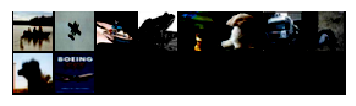

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


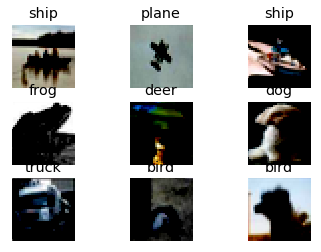

In [12]:
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(images[i,:])
    plt.title(classes[labels[i].item()])

In [13]:
def get_stats(loader):   
    '''
    Compute training statistics (loss and accuracy) on loader data
    '''
    loss = 0.0
    correct = 0
    total = 0       
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        l = loss.to('cpu').item()/total
        acc = 100 * correct/total
        return [l,acc]

# Initialize network, optimizer and loss

In [14]:
from cifar10_archs import Net
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [15]:
print(model)
print( summary(model, imgs_shape) )

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]            2416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]           48120
            Linear-6                   [-1, 84]           10164
            Linear-7                   [-1, 10]             850
Total params: tensor(62006)
T

In [16]:
train_stats = []
test_stats  = []
fractions   = []
params_stats= []
grad_stats  = []
grad2_stats = []
snr_stats   = []

for epoch in tqdm(range(epochs)):
    
    # init to zero accumulators for grad and grad2
    grad  = init_grad(model)
    grad2 = init_grad(model)  
    
    count = 0
    
    for i, data in enumerate(train_loader, 0):
                               
        # get the inputs and load it on device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
       
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
                
        # accumulate grad and grad2
        grad  = acc_grad(grad,model)
        grad2 = acc_grad2(grad2,model)
        
        if (i + 1) % n == 0 :
            
            count += 1
            #print('Epoch : {} mini-epoch/tot : {}/{}'.format(epoch, count, n_lb) )
            
            with torch.no_grad():
                
                # compute the snr 
                snr = compute_snr(grad, grad2, n)

                # temper the grad with the information on grad2
                fr = []
                grad_copy = []
                                              
                for p, g, s in zip(model.parameters(), grad, snr): 
                    grad_copy.append(p.grad.clone())
                    
                    # This is the only line where the true gradient is touched
                    # it substitute the gradient p.grad (that is the one computed on
                    # the last mini-batch, since optimizer.zero_grad() is always called)
                    # with the gradient accumulated in acc_grad. This gradient is averaged
                    # over the number of mini-batches in a large batch, so it is divided
                    # by n.
                    
                    # If we use the modified SGD, when the signal to noise 
                    # ratio is > 1 we leave grad untouched, otherwise the gradient is 
                    # multiplied by the signal to noise ratio value
                    
                    if MODIFIED_SGD:
                        p.grad = torch.where(s > 1, g/n, s * g/n)          
                    else:
                        p.grad = g/n
                        
                    fr.append(  ( s < 1).sum().item() / 
                             torch.prod(torch.tensor( s.size() ) ).item()  )       
            fractions.append(fr)        
    
            # store statistics about params grad, grad2 and snr    
            params_stats.append([ [x.mean().item(), x.std().item()]  for x in model.parameters() ] )
            grad_stats.append(  [ [x.mean().item(), x.std().item()]  for x in grad] )
            grad2_stats.append( [ [x.mean().item(), x.std().item()]  for x in grad2] )
            snr_stats.append(   [ [x.mean().item(), x.std().item()]  for x in snr] )
        
            # this is called after the large batch of n mini-batches
            optimizer.step()
            
            # set to zero accumulators for grad and grad2
            grad  = init_grad(model)
            grad2 = init_grad(model)
            
                          
    # save model
    if SAVE:
        #model.save_state_dict(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # get statistics
    train_stats.append(get_stats(train_loader))
    test_stats.append(get_stats(test_loader))
        
    # print statistics
    print('Train loss : %g --- Train acc : %g %%' % ( train_stats[-1][0], train_stats[-1][1] )) 
    print('Test  loss : %g --- Test  acc : %g %%' % ( test_stats[-1][0],  test_stats[-1][1] ))         

  1%|          | 1/100 [00:13<21:48, 13.22s/it]

Train loss : 0.230111 --- Train acc : 14.906 %
Test  loss : 0.230108 --- Test  acc : 14.74 %


  2%|▏         | 2/100 [00:26<21:43, 13.30s/it]

Train loss : 0.229805 --- Train acc : 14.656 %
Test  loss : 0.229797 --- Test  acc : 14.56 %


  3%|▎         | 3/100 [00:39<21:33, 13.33s/it]

Train loss : 0.22886 --- Train acc : 14.134 %
Test  loss : 0.228828 --- Test  acc : 14.07 %


  4%|▍         | 4/100 [00:53<21:20, 13.34s/it]

Train loss : 0.219254 --- Train acc : 19.618 %
Test  loss : 0.218984 --- Test  acc : 19.39 %


  5%|▌         | 5/100 [01:06<21:10, 13.37s/it]

Train loss : 0.203188 --- Train acc : 26.714 %
Test  loss : 0.202553 --- Test  acc : 27.55 %


  6%|▌         | 6/100 [01:20<20:57, 13.38s/it]

Train loss : 0.18829 --- Train acc : 30.44 %
Test  loss : 0.187421 --- Test  acc : 31.4 %


  7%|▋         | 7/100 [01:33<20:47, 13.41s/it]

Train loss : 0.210364 --- Train acc : 28.374 %
Test  loss : 0.210025 --- Test  acc : 27.74 %


  8%|▊         | 8/100 [01:47<20:32, 13.39s/it]

Train loss : 0.180892 --- Train acc : 34.506 %
Test  loss : 0.180124 --- Test  acc : 35.03 %


  9%|▉         | 9/100 [02:00<20:18, 13.40s/it]

Train loss : 0.17345 --- Train acc : 37.38 %
Test  loss : 0.173001 --- Test  acc : 37.84 %


 10%|█         | 10/100 [02:14<20:10, 13.45s/it]

Train loss : 0.1627 --- Train acc : 40.61 %
Test  loss : 0.162141 --- Test  acc : 41.27 %


 11%|█         | 11/100 [02:28<19:57, 13.46s/it]

Train loss : 0.162472 --- Train acc : 41.31 %
Test  loss : 0.161639 --- Test  acc : 41.63 %


 12%|█▏        | 12/100 [02:42<19:53, 13.56s/it]

Train loss : 0.158151 --- Train acc : 42.032 %
Test  loss : 0.157304 --- Test  acc : 42.16 %


 13%|█▎        | 13/100 [02:56<19:37, 13.54s/it]

Train loss : 0.156377 --- Train acc : 43.378 %
Test  loss : 0.155728 --- Test  acc : 43.73 %


 14%|█▍        | 14/100 [03:10<19:31, 13.62s/it]

Train loss : 0.15357 --- Train acc : 44.246 %
Test  loss : 0.153231 --- Test  acc : 43.9 %


 15%|█▌        | 15/100 [03:24<19:16, 13.61s/it]

Train loss : 0.156789 --- Train acc : 43.798 %
Test  loss : 0.156233 --- Test  acc : 44.06 %


 16%|█▌        | 16/100 [03:37<19:01, 13.59s/it]

Train loss : 0.150298 --- Train acc : 45.446 %
Test  loss : 0.150285 --- Test  acc : 45.51 %


 17%|█▋        | 17/100 [03:51<18:50, 13.62s/it]

Train loss : 0.14822 --- Train acc : 46.25 %
Test  loss : 0.147931 --- Test  acc : 46.64 %


 18%|█▊        | 18/100 [04:05<18:38, 13.64s/it]

Train loss : 0.14344 --- Train acc : 47.974 %
Test  loss : 0.14363 --- Test  acc : 48.06 %


 19%|█▉        | 19/100 [04:19<18:25, 13.65s/it]

Train loss : 0.142428 --- Train acc : 48.224 %
Test  loss : 0.142683 --- Test  acc : 48.14 %


 20%|██        | 20/100 [04:33<18:12, 13.65s/it]

Train loss : 0.137378 --- Train acc : 50.738 %
Test  loss : 0.138338 --- Test  acc : 50 %


 21%|██        | 21/100 [04:46<17:58, 13.66s/it]

Train loss : 0.139379 --- Train acc : 49.396 %
Test  loss : 0.140765 --- Test  acc : 48.8 %


 22%|██▏       | 22/100 [05:01<17:47, 13.69s/it]

Train loss : 0.134058 --- Train acc : 52.03 %
Test  loss : 0.136029 --- Test  acc : 51.17 %


 23%|██▎       | 23/100 [05:14<17:34, 13.69s/it]

Train loss : 0.134407 --- Train acc : 51.298 %
Test  loss : 0.136356 --- Test  acc : 50.22 %


 24%|██▍       | 24/100 [05:29<17:23, 13.72s/it]

Train loss : 0.133537 --- Train acc : 52.084 %
Test  loss : 0.136074 --- Test  acc : 51.21 %


 25%|██▌       | 25/100 [05:43<17:09, 13.72s/it]

Train loss : 0.132373 --- Train acc : 52.508 %
Test  loss : 0.135338 --- Test  acc : 51.14 %


 26%|██▌       | 26/100 [05:57<16:56, 13.74s/it]

Train loss : 0.126922 --- Train acc : 54.754 %
Test  loss : 0.13008 --- Test  acc : 53.71 %


 27%|██▋       | 27/100 [06:11<16:43, 13.75s/it]

Train loss : 0.130909 --- Train acc : 53.38 %
Test  loss : 0.134572 --- Test  acc : 51.75 %


 28%|██▊       | 28/100 [06:25<16:30, 13.75s/it]

Train loss : 0.127058 --- Train acc : 54.566 %
Test  loss : 0.131643 --- Test  acc : 53.01 %


 29%|██▉       | 29/100 [06:39<16:17, 13.77s/it]

Train loss : 0.125926 --- Train acc : 55.268 %
Test  loss : 0.130555 --- Test  acc : 53.61 %


 30%|███       | 30/100 [06:54<16:06, 13.80s/it]

Train loss : 0.123046 --- Train acc : 56.158 %
Test  loss : 0.127684 --- Test  acc : 54.61 %


 31%|███       | 31/100 [07:08<15:53, 13.83s/it]

Train loss : 0.126447 --- Train acc : 55.552 %
Test  loss : 0.131499 --- Test  acc : 53.73 %


 32%|███▏      | 32/100 [07:22<15:40, 13.83s/it]

Train loss : 0.124853 --- Train acc : 56.186 %
Test  loss : 0.130054 --- Test  acc : 53.98 %


 33%|███▎      | 33/100 [07:36<15:27, 13.84s/it]

Train loss : 0.117121 --- Train acc : 58.572 %
Test  loss : 0.123723 --- Test  acc : 55.82 %


 34%|███▍      | 34/100 [07:51<15:14, 13.85s/it]

Train loss : 0.121027 --- Train acc : 57.148 %
Test  loss : 0.127263 --- Test  acc : 54.01 %


 35%|███▌      | 35/100 [08:05<15:02, 13.88s/it]

Train loss : 0.115313 --- Train acc : 59.068 %
Test  loss : 0.122116 --- Test  acc : 56.26 %


 36%|███▌      | 36/100 [08:20<14:49, 13.90s/it]

Train loss : 0.115642 --- Train acc : 59.082 %
Test  loss : 0.123102 --- Test  acc : 56.7 %


 37%|███▋      | 37/100 [08:35<14:37, 13.92s/it]

Train loss : 0.111678 --- Train acc : 60.7 %
Test  loss : 0.119474 --- Test  acc : 57.76 %


 38%|███▊      | 38/100 [08:49<14:23, 13.93s/it]

Train loss : 0.111938 --- Train acc : 60.33 %
Test  loss : 0.120164 --- Test  acc : 57.11 %


 39%|███▉      | 39/100 [09:03<14:09, 13.93s/it]

Train loss : 0.110522 --- Train acc : 61.116 %
Test  loss : 0.119211 --- Test  acc : 57.64 %


 40%|████      | 40/100 [09:17<13:55, 13.93s/it]

Train loss : 0.111029 --- Train acc : 60.552 %
Test  loss : 0.120202 --- Test  acc : 56.87 %


 41%|████      | 41/100 [09:30<13:41, 13.92s/it]

Train loss : 0.110464 --- Train acc : 60.7 %
Test  loss : 0.120455 --- Test  acc : 57.1 %


 42%|████▏     | 42/100 [09:45<13:28, 13.93s/it]

Train loss : 0.110617 --- Train acc : 60.466 %
Test  loss : 0.121038 --- Test  acc : 56.83 %


 43%|████▎     | 43/100 [10:00<13:15, 13.96s/it]

Train loss : 0.109295 --- Train acc : 61.81 %
Test  loss : 0.120233 --- Test  acc : 57.96 %


 44%|████▍     | 44/100 [10:14<13:01, 13.96s/it]

Train loss : 0.109627 --- Train acc : 61.144 %
Test  loss : 0.1202 --- Test  acc : 57.27 %


 45%|████▌     | 45/100 [10:28<12:48, 13.96s/it]

Train loss : 0.10538 --- Train acc : 62.862 %
Test  loss : 0.116591 --- Test  acc : 58.96 %


 46%|████▌     | 46/100 [10:43<12:34, 13.98s/it]

Train loss : 0.108261 --- Train acc : 61.664 %
Test  loss : 0.120659 --- Test  acc : 57.34 %


 47%|████▋     | 47/100 [10:56<12:20, 13.98s/it]

Train loss : 0.113775 --- Train acc : 60.076 %
Test  loss : 0.125184 --- Test  acc : 55.46 %


 48%|████▊     | 48/100 [11:10<12:06, 13.97s/it]

Train loss : 0.113487 --- Train acc : 60.456 %
Test  loss : 0.126546 --- Test  acc : 56.05 %


 49%|████▉     | 49/100 [11:24<11:52, 13.98s/it]

Train loss : 0.103123 --- Train acc : 63.916 %
Test  loss : 0.116781 --- Test  acc : 58.73 %


 50%|█████     | 50/100 [11:39<11:39, 14.00s/it]

Train loss : 0.100616 --- Train acc : 64.416 %
Test  loss : 0.115209 --- Test  acc : 59.31 %


 51%|█████     | 51/100 [11:53<11:25, 14.00s/it]

Train loss : 0.108849 --- Train acc : 61.77 %
Test  loss : 0.12338 --- Test  acc : 57.34 %


 52%|█████▏    | 52/100 [12:08<11:12, 14.01s/it]

Train loss : 0.103882 --- Train acc : 63.608 %
Test  loss : 0.119783 --- Test  acc : 58.31 %


 53%|█████▎    | 53/100 [12:22<10:58, 14.02s/it]

Train loss : 0.0987604 --- Train acc : 65.154 %
Test  loss : 0.114671 --- Test  acc : 59.36 %


 54%|█████▍    | 54/100 [12:37<10:45, 14.03s/it]

Train loss : 0.0969842 --- Train acc : 65.958 %
Test  loss : 0.114484 --- Test  acc : 59.6 %


 55%|█████▌    | 55/100 [12:51<10:31, 14.03s/it]

Train loss : 0.0980542 --- Train acc : 65.368 %
Test  loss : 0.115454 --- Test  acc : 59.39 %


 56%|█████▌    | 56/100 [13:05<10:17, 14.03s/it]

Train loss : 0.101273 --- Train acc : 64.698 %
Test  loss : 0.120233 --- Test  acc : 58.64 %


 57%|█████▋    | 57/100 [13:19<10:03, 14.03s/it]

Train loss : 0.10288 --- Train acc : 64.064 %
Test  loss : 0.120245 --- Test  acc : 58.01 %


 58%|█████▊    | 58/100 [13:33<09:49, 14.02s/it]

Train loss : 0.0955047 --- Train acc : 66.778 %
Test  loss : 0.115385 --- Test  acc : 59.7 %


 59%|█████▉    | 59/100 [13:47<09:35, 14.03s/it]

Train loss : 0.0994474 --- Train acc : 64.274 %
Test  loss : 0.119623 --- Test  acc : 58.41 %


 60%|██████    | 60/100 [14:01<09:21, 14.03s/it]

Train loss : 0.0977777 --- Train acc : 65.2 %
Test  loss : 0.118648 --- Test  acc : 58.79 %


 61%|██████    | 61/100 [14:15<09:07, 14.03s/it]

Train loss : 0.0949928 --- Train acc : 66.934 %
Test  loss : 0.115174 --- Test  acc : 59.36 %


 62%|██████▏   | 62/100 [14:30<08:53, 14.04s/it]

Train loss : 0.0936621 --- Train acc : 66.81 %
Test  loss : 0.115973 --- Test  acc : 59.59 %


 63%|██████▎   | 63/100 [14:44<08:39, 14.04s/it]

Train loss : 0.0978444 --- Train acc : 65.342 %
Test  loss : 0.119092 --- Test  acc : 58.86 %


 64%|██████▍   | 64/100 [14:59<08:25, 14.05s/it]

Train loss : 0.0884471 --- Train acc : 68.74 %
Test  loss : 0.112414 --- Test  acc : 60.02 %


 65%|██████▌   | 65/100 [15:13<08:11, 14.05s/it]

Train loss : 0.0892749 --- Train acc : 68.516 %
Test  loss : 0.113841 --- Test  acc : 60.31 %


 66%|██████▌   | 66/100 [15:27<07:58, 14.06s/it]

Train loss : 0.0857842 --- Train acc : 69.922 %
Test  loss : 0.111973 --- Test  acc : 61.63 %


 67%|██████▋   | 67/100 [15:41<07:43, 14.06s/it]

Train loss : 0.0882438 --- Train acc : 68.898 %
Test  loss : 0.114184 --- Test  acc : 60.41 %


 68%|██████▊   | 68/100 [15:56<07:30, 14.06s/it]

Train loss : 0.0923376 --- Train acc : 67.832 %
Test  loss : 0.117783 --- Test  acc : 59.94 %


 69%|██████▉   | 69/100 [16:10<07:16, 14.07s/it]

Train loss : 0.0880608 --- Train acc : 68.562 %
Test  loss : 0.115968 --- Test  acc : 59.86 %


 70%|███████   | 70/100 [16:24<07:02, 14.07s/it]

Train loss : 0.0830703 --- Train acc : 71.1 %
Test  loss : 0.111295 --- Test  acc : 61.22 %


 71%|███████   | 71/100 [16:39<06:48, 14.08s/it]

Train loss : 0.0845573 --- Train acc : 70.386 %
Test  loss : 0.113545 --- Test  acc : 60.57 %


 72%|███████▏  | 72/100 [16:54<06:34, 14.09s/it]

Train loss : 0.0873797 --- Train acc : 68.834 %
Test  loss : 0.117886 --- Test  acc : 59.2 %


 73%|███████▎  | 73/100 [17:09<06:20, 14.10s/it]

Train loss : 0.0899975 --- Train acc : 67.794 %
Test  loss : 0.120603 --- Test  acc : 58.89 %


 74%|███████▍  | 74/100 [17:23<06:06, 14.10s/it]

Train loss : 0.0800997 --- Train acc : 72.088 %
Test  loss : 0.112545 --- Test  acc : 61.64 %


 75%|███████▌  | 75/100 [17:38<05:52, 14.11s/it]

Train loss : 0.0780174 --- Train acc : 73.012 %
Test  loss : 0.110412 --- Test  acc : 61.88 %


 76%|███████▌  | 76/100 [17:52<05:38, 14.11s/it]

Train loss : 0.0858021 --- Train acc : 69.472 %
Test  loss : 0.119506 --- Test  acc : 59.48 %


 77%|███████▋  | 77/100 [18:06<05:24, 14.12s/it]

Train loss : 0.0840023 --- Train acc : 70.566 %
Test  loss : 0.118584 --- Test  acc : 60.59 %


 78%|███████▊  | 78/100 [18:21<05:10, 14.13s/it]

Train loss : 0.0856436 --- Train acc : 69.892 %
Test  loss : 0.118072 --- Test  acc : 60.21 %


 79%|███████▉  | 79/100 [18:35<04:56, 14.12s/it]

Train loss : 0.0797074 --- Train acc : 71.81 %
Test  loss : 0.116043 --- Test  acc : 60.39 %


 80%|████████  | 80/100 [18:50<04:42, 14.13s/it]

Train loss : 0.0859517 --- Train acc : 69.826 %
Test  loss : 0.122482 --- Test  acc : 59.38 %


 81%|████████  | 81/100 [19:04<04:28, 14.13s/it]

Train loss : 0.0863715 --- Train acc : 69.64 %
Test  loss : 0.123468 --- Test  acc : 58.79 %


 82%|████████▏ | 82/100 [19:18<04:14, 14.13s/it]

Train loss : 0.0792205 --- Train acc : 72.372 %
Test  loss : 0.117115 --- Test  acc : 60.38 %


 83%|████████▎ | 83/100 [19:33<04:00, 14.14s/it]

Train loss : 0.07955 --- Train acc : 72.032 %
Test  loss : 0.118233 --- Test  acc : 60.12 %


 84%|████████▍ | 84/100 [19:47<03:46, 14.14s/it]

Train loss : 0.0815462 --- Train acc : 71.096 %
Test  loss : 0.119995 --- Test  acc : 59.56 %


 85%|████████▌ | 85/100 [20:02<03:32, 14.14s/it]

Train loss : 0.0757662 --- Train acc : 73.534 %
Test  loss : 0.116167 --- Test  acc : 61.23 %


 86%|████████▌ | 86/100 [20:16<03:17, 14.14s/it]

Train loss : 0.0761241 --- Train acc : 72.978 %
Test  loss : 0.118002 --- Test  acc : 61.29 %


 87%|████████▋ | 87/100 [20:30<03:03, 14.15s/it]

Train loss : 0.0785476 --- Train acc : 72.178 %
Test  loss : 0.120768 --- Test  acc : 59.64 %


 88%|████████▊ | 88/100 [20:44<02:49, 14.15s/it]

Train loss : 0.0734399 --- Train acc : 74.09 %
Test  loss : 0.116524 --- Test  acc : 61.15 %


 89%|████████▉ | 89/100 [20:59<02:35, 14.16s/it]

Train loss : 0.0720339 --- Train acc : 75.012 %
Test  loss : 0.114634 --- Test  acc : 61.41 %


 90%|█████████ | 90/100 [21:15<02:21, 14.17s/it]

Train loss : 0.0755957 --- Train acc : 73.244 %
Test  loss : 0.121653 --- Test  acc : 60.4 %


 91%|█████████ | 91/100 [21:29<02:07, 14.17s/it]

Train loss : 0.072638 --- Train acc : 74.434 %
Test  loss : 0.11711 --- Test  acc : 61.12 %


 92%|█████████▏| 92/100 [21:44<01:53, 14.17s/it]

Train loss : 0.0668404 --- Train acc : 77.136 %
Test  loss : 0.11351 --- Test  acc : 62.4 %


 93%|█████████▎| 93/100 [21:58<01:39, 14.17s/it]

Train loss : 0.0693525 --- Train acc : 75.698 %
Test  loss : 0.117855 --- Test  acc : 60.99 %


 94%|█████████▍| 94/100 [22:12<01:25, 14.18s/it]

Train loss : 0.069288 --- Train acc : 75.612 %
Test  loss : 0.119051 --- Test  acc : 60.6 %


 95%|█████████▌| 95/100 [22:26<01:10, 14.18s/it]

Train loss : 0.0669745 --- Train acc : 76.838 %
Test  loss : 0.117434 --- Test  acc : 61.73 %


 96%|█████████▌| 96/100 [22:41<00:56, 14.18s/it]

Train loss : 0.0739793 --- Train acc : 73.482 %
Test  loss : 0.122554 --- Test  acc : 59.69 %


 97%|█████████▋| 97/100 [22:55<00:42, 14.18s/it]

Train loss : 0.0680075 --- Train acc : 76.024 %
Test  loss : 0.119923 --- Test  acc : 60.5 %


 98%|█████████▊| 98/100 [23:10<00:28, 14.19s/it]

Train loss : 0.0829007 --- Train acc : 70.428 %
Test  loss : 0.132525 --- Test  acc : 57.59 %


 99%|█████████▉| 99/100 [23:25<00:14, 14.19s/it]

Train loss : 0.0733322 --- Train acc : 73.998 %
Test  loss : 0.126304 --- Test  acc : 59.49 %


100%|██████████| 100/100 [23:39<00:00, 14.20s/it]

Train loss : 0.066379 --- Train acc : 76.46 %
Test  loss : 0.121131 --- Test  acc : 60.36 %


In [17]:
# save loss and accuracies in a dictionary
train_stats = np.asarray(train_stats)
test_stats  = np.asarray(test_stats)
fractions   = np.asarray(fractions)
params_stats= np.asarray(params_stats)
grad_stats  = np.asarray(grad_stats)
grad2_stats = np.asarray(grad2_stats)
snr_stats   = np.asarray(snr_stats)

tags = ['train_stats', 'test_stats', 'fractions', 'params_stats', 'grad_stats', 'grad2_stats', 'snr_stats' ]
vals = [train_stats, test_stats, fractions, params_stats, grad_stats, grad2_stats, snr_stats ]
training_data = dict(zip(tags, vals))
if SAVE:
    file = open( os.path.join( RES, 'training_data.pt') , 'wb' ) 
    pickle.dump(training_data,file)

In [18]:
win = 30
nchecks = int( np.floor(len(train_loader.dataset)/(mb_size*n) ))
layer_names = [m[0] for idx,m in enumerate(model.named_modules()) ]
layer_names.remove('')
layer_names.remove('pool')
print(layer_names)

['conv1', 'conv2', 'fc1', 'fc2', 'fc3']


In [19]:
def plot_results(figname, train_stats, test_stats, fractions, grad_stats, grad2_stats):

    fig = plt.figure(figsize=(20,20))
    plt.subplot(4,4,1)
    plt.plot(train_stats[:,0],'-',label='training loss')
    plt.plot(test_stats[:,0],'-',label='test loss')
    plt.xlabel('epoch')
    plt.title('loss')
    plt.legend()

    plt.subplot(4,4,2)
    plt.plot(train_stats[:,1],'-',label='training accuracy')
    plt.plot(test_stats[:,1],'-',label='test accuracy')
    plt.xlabel('epoch')
    plt.title('accuracy')
    plt.legend()

    plt.subplot(4,4,3)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean(fractions[:,i*2], win ),label=layer_names[i] ) 
    plt.legend()
    plt.xlabel('epoch')
    plt.title('fraction of $\eta < 1$')

    plt.subplot(4,4,4)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,0], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad mean')

    plt.subplot(4,4,5)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad_stats[:,i*2,1], win ),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad std')

    plt.subplot(4,4,6)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 mean')

    plt.subplot(4,4,7)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( grad2_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('grad2 std')

    plt.subplot(4,4,8)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,0], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr mean')

    plt.subplot(4,4,9)
    for i in range(len(layer_names)):
        plt.plot(np.arange(nchecks*epochs)/nchecks, pd.rolling_mean( snr_stats[:,i*2,1], win),label=layer_names[i])
    plt.legend()
    plt.xlabel('epoch')
    plt.title('snr std')

    plt.savefig(os.path.join(FIG, figname))
    
    plt.show()


/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:27: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:34: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:41: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:48: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykerne

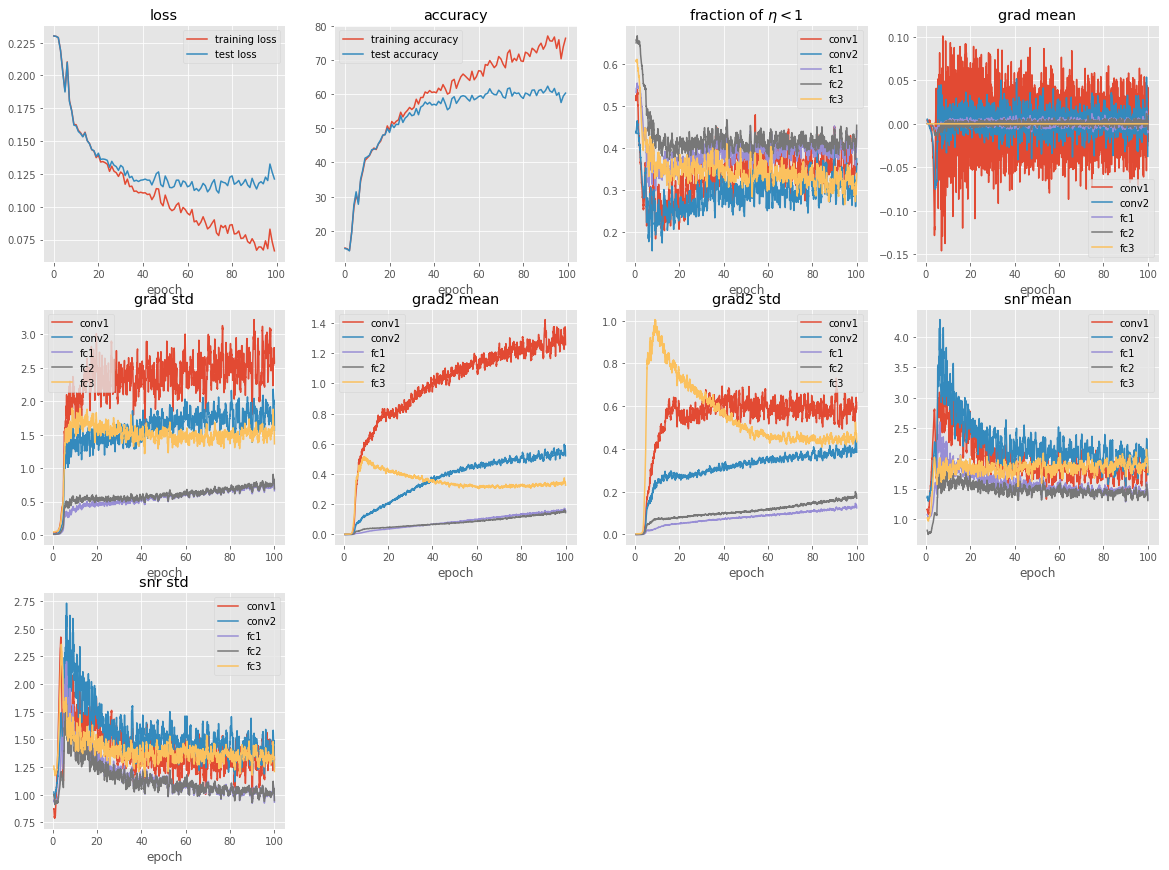

In [20]:
plot_results(DATASET, train_stats, test_stats, fractions, grad_stats, grad2_stats)